# Compute Line Forces

In [ ]:
from scipy.optimize import linprog
import numpy as np

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_uppercase

Missing items:
1. Spool compensation
2. Spring compensation
3. Auto-calibration
    1. Torque Mode
    2. Encoder reading
    3. Torque reading

Practical torques for tightening lines in daily use tend to lie between 0.1 Nm and 0.001 Nm for a Hangprinter.

Be very careful with torque mode on free spinning motors!!

https://github.com/Klipper3d/klipper/blob/f97fd7c6e392e376bd1552afdd39a2150d3e21d0/klippy/gcode.py#L141

### Parameters

In [ ]:
# in Newtons
min_tension = 1  # tobben uses 20
max_tension = 70  # tobben uses 70
weight = 20

# for plots
build_plate_x = 100
build_plate_y = 100

In [ ]:

/* Naive buildup factor calculation (assumes cylindrical, straight line)
	 * line diameter: 0.5 mm
	 * spool height: 8.0 mm
	 * (line_cross_section_area)/(height*pi): ((0.5/2)*(0.5/2)*pi)/(8.0*pi) = 0.0078 mm
	 * Default buildup factor for 0.50 mm FireLine: 0.0078
	 * Default buildup factor for 0.39 mm FireLine: 0.00475
	 * In practice you might want to compensate a bit more or a bit less */
	constexpr float DefaultSpoolBuildupFactor = 0.007;
	/* Measure and set spool radii with M669 to achieve better accuracy */
	constexpr float DefaultSpoolRadii[4] = { 75.0, 75.0, 75.0, 75.0}; // HP4 default

In [ ]:

	//// Line buildup compensation
	float stepsPerUnitTimesRTmp[HANGPRINTER_AXES] = { 0.0 };
	Platform& platform = reprap.GetPlatform(); // No const because we want to set drive steper per unit
	for (size_t i = 0; i < HANGPRINTER_AXES; i++)
	{
		const uint8_t driver = platform.GetAxisDriversConfig(i).driverNumbers[0].localDriver; // Only supports single driver
		bool dummy;
		stepsPerUnitTimesRTmp[i] =
			(
				(float)(mechanicalAdvantage[i])
				* fullStepsPerMotorRev[i]
				* platform.GetMicrostepping(driver, dummy)
				* spoolGearTeeth[i]
			)
			/ (2.0 * Pi * motorGearTeeth[i]);

		k2[i] = -(float)(mechanicalAdvantage[i] * linesPerSpool[i]) * spoolBuildupFactor;
		k0[i] = 2.0 * stepsPerUnitTimesRTmp[i] / k2[i];
		spoolRadiiSq[i] = spoolRadii[i] * spoolRadii[i];

		// Calculate the steps per unit that is correct at the origin
		platform.SetDriveStepsPerUnit(i, stepsPerUnitTimesRTmp[i] / spoolRadii[i], 0);
	}

In [ ]:
	//// Line buildup compensation
	float stepsPerUnitTimesRTmp[HANGPRINTER_AXES] = { 0.0 };
	Platform& platform = reprap.GetPlatform(); // No const because we want to set drive steper per unit
	for (size_t i = 0; i < HANGPRINTER_AXES; i++)
	{
		const uint8_t driver = platform.GetAxisDriversConfig(i).driverNumbers[0].localDriver; // Only supports single driver
		bool dummy;
		stepsPerUnitTimesRTmp[i] =
			(
				(float)(mechanicalAdvantage[i])
				* fullStepsPerMotorRev[i]
				* platform.GetMicrostepping(driver, dummy)
				* spoolGearTeeth[i]
			)
			/ (2.0 * Pi * motorGearTeeth[i]);

		k2[i] = -(float)(mechanicalAdvantage[i] * linesPerSpool[i]) * spoolBuildupFactor;
		k0[i] = 2.0 * stepsPerUnitTimesRTmp[i] / k2[i];
		spoolRadiiSq[i] = spoolRadii[i] * spoolRadii[i];

		// Calculate the steps per unit that is correct at the origin
		platform.SetDriveStepsPerUnit(i, stepsPerUnitTimesRTmp[i] / spoolRadii[i], 0);
	}

### Functions

In [ ]:
def _compute_static_forces(min_tension, max_tension, weight, anchors, position):
    v_dirs = anchors - position[:, None]
    u_vectors = v_dirs / np.sqrt(np.sum(v_dirs**2, axis=0))
    # print('u_vectors', u_vectors)

    c = np.ones([anchors.shape[1]])
    A_eq = u_vectors
    # print('A_ub\n', A_eq)
    # add gravity
    b_eq = np.array([0]*(anchors.shape[0]-1) + [weight])
    bounds = np.array([[min_tension]*anchors.shape[1], [max_tension]*anchors.shape[1]]).T

    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

    # print('cost', res.fun)
    # print('lagrange\n', res.ineqlin)
    if res.success:
        return res.x
    else:
        raise ValueError(f'Optimization failed. {res.message}')

In [ ]:
def cramer3x3(a, b, det_a):
  mask = np.broadcast_to(np.diag([1,1,1]), [3, 3, 3]).swapaxes(0, 1)
  Ms = np.where(mask, np.repeat(b, 3).reshape(3, 3), a)
  return np.linalg.det(Ms) / det_a

In [ ]:
def cramer2x2(a, b, det_a):
    a_x = np.hstack([b[:, None], a[:, 1:2]])
    a_y = np.hstack([a[:, 0:1], b[:, None]])
    det_x = np.linalg.det(a_x)
    det_y = np.linalg.det(a_y)
    x = det_x/det_a
    y = det_y/det_a
    return np.array([x, y])

In [ ]:
fix_1, fix_2 = 1,2
sorted(list(set(range(4))-set([fix_1, fix_2])))

[0, 3]

In [ ]:
def iter_solve(A, b, bounds):
    # based on https://stackoverflow.com/a/35949930
    # we have 4 motors, 3 dimensions (x, y, z) and bounds for every motor
    # so 3 equations, 4 tensions to find
    # evaluate one tension at a time for min_bound and max_bound
    # then solve 3x3 system via cramer
    # then check if feasible
    # last, among feasible find optimal
    min_tension, max_tension = bounds
    sols = []
    # alls = []
    for i in range(A.shape[1]):
        A_s = A[:, [j for j in range(A.shape[1]) if i != j]]  # take out column i
        det_As = np.linalg.det(A_s)
        for tension in [min_tension, max_tension]:
            b_s = b - A[:, i]*tension  # evaluate i at bound
            s = cramer3x3(A_s, b_s, det_As)
            if all(s <= max_tension) and all(s >= min_tension):
                sols.append(np.concatenate([s[:i], np.array([tension]), s[i:]]))
            # alls.append(np.concatenate([s[:i], np.array([tension]), s[i:]]))
    # print('all sols\n', alls)
    # could be a restriction colinearity case, with dual bounds
    if len(sols) == 1 and any(sols[0] == max_tension):
        col_combos = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
        row_combos = [[0, 1], [0, 2], [1, 2]]
        for row_combo in row_combos:
            for fix_1, fix_2 in [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]:
                sub_A = A[row_combo, :]
                A_s = sub_A[:, [j for j in range(A.shape[1]) if fix_1 != j and fix_2 != j]]  # take out column i and first row
                det_As = np.linalg.det(A_s)
                # wrong rows
                if det_As <= 0:
                    continue
                b_s = b[[0,2]] - (sub_A[:, fix_1] + sub_A[:, fix_2])*min_tension  # evaluate both columns at bound
                s = cramer2x2(A_s, b_s, det_As)
                full_sol = np.zeros(4)
                full_sol[fix_1] = min_tension
                full_sol[fix_2] = min_tension
                for sol, sol_idx in zip(s, sorted(list(set(range(4))-set([fix_1, fix_2])))):
                    full_sol[sol_idx] = sol
                # print('full sol', full_sol)
                # alls.append(full_sol)
                if all(s <= max_tension) and all(s >= min_tension):
                    sols.append(full_sol)
        # print('all alt sols\n', alls)
    if len(sols) == 0:
        return None
    # print('feasible sols\n', sols)
    cost = np.abs(np.array(sols)).sum(axis=1)
    # print('cost', cost)
    min_sol_idx = np.argmin(cost)
    # print('min_sol_idx', min_sol_idx)
    min_sol = sols[min_sol_idx]
    return min_sol

In [ ]:
def _compute_static_forces_iter(min_tension, max_tension, weight, anchors, position):
    v_dirs = anchors - position[:, None]
    u_vectors = v_dirs / np.sqrt(np.sum(v_dirs**2, axis=0))
    # print('anchors', anchors)
    # print('position', position)
    # print('u_vectors', u_vectors)

    c = np.ones([anchors.shape[1]])
    A_eq = u_vectors
    # add gravity
    b_eq = np.array([0]*(anchors.shape[0]-1) + [weight])

    res = iter_solve(A=A_eq, b=b_eq, bounds=[min_tension, max_tension])

    # print('cost', res.fun)
    # print('lagrange\n', res.ineqlin)
    if res is not None:
        return res
    else:
        raise ValueError(f'Optimization failed.')

In [ ]:
A = np.array([[-0.70710678, -0.70710678,  1.,          0.        ],
            [-0.70710678,  0.70710678,  0.,          0.        ],
            [ 0.,          0.,          0.,          1.        ]])

b = np.array([0, 0, weight])
iter_solve(A, b, [min_tension, max_tension])

<ipython-input-5-190dc06b28b0>:4: RuntimeWarning: divide by zero encountered in divide
  return np.linalg.det(Ms) / det_a


array([ 0.1       ,  0.1       ,  0.14142136, 20.        ])

In [ ]:
def optimize_heatmap_iter(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y, z_height=1.0):
    x = np.arange(0, build_plate_x, 1)
    y = np.arange(0, build_plate_y, 1)
    xx, yy = np.meshgrid(x, y, sparse=False)

    grid = np.vstack([xx.ravel(), yy.ravel(), [z_height]*len(x)*len(y)]).T

    forces = []
    for point in grid:
        try:
            forces.append(_compute_static_forces_iter(min_tension, max_tension, weight, anchors, point))
        except Exception as e:
            forces.append([max_tension]*anchors.shape[1])
    forces = np.array(forces)
    return grid, forces

In [ ]:
def optimize_heatmap(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y, z_height=1.0):
    x = np.arange(0, build_plate_x, 1)
    y = np.arange(0, build_plate_y, 1)
    xx, yy = np.meshgrid(x, y, sparse=False)

    grid = np.vstack([xx.ravel(), yy.ravel(), [z_height]*len(x)*len(y)]).T

    forces = []
    for point in grid:
        try:
            forces.append(_compute_static_forces(min_tension, max_tension, weight, anchors, point))
        except Exception as e:
            forces.append([max_tension]*anchors.shape[1])
    forces = np.array(forces)
    return grid, forces

In [ ]:
def plot_heatmap(grid, forces, anchors, plot_max_force=30):
    data = pd.DataFrame(np.hstack([grid[:, :2], forces.sum(axis=1)[:, None]]), columns=['x', 'y', 'total_force']).pivot('y', 'x', 'total_force')
    sns.heatmap(data, cmap='vlag', vmax=plot_max_force*(anchors.shape[1]-1)).set(title=f'Total Static Forces')
    plt.gca().invert_yaxis()
    plt.show()

    for i, axis in enumerate(ascii_uppercase[:anchors.shape[1]]):
        data = pd.DataFrame(np.hstack([grid[:, :2], forces[:, i:(i+1)]]), columns=['x', 'y', f'force_{axis}'])
        data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')
        sns.heatmap(data, vmax=plot_max_force, cmap='vlag').set(title=f'Line {axis}')
        plt.gca().invert_yaxis()
        plt.show()

## 3 Lines

In [ ]:
anchors = np.array([[0, 0, 100, 50],
                    [0, 100, 50, 50],
                    [0, 0, 0, 100]])

In [ ]:
_compute_static_forces(min_tension=0.1, max_tension=200, weight=weight, anchors=anchors, position=np.array([51, 50, 10.]))

array([ 0.1       ,  0.1       ,  0.37231169, 20.10342063])

In [ ]:
_compute_static_forces_iter(min_tension=0.1, max_tension=200, weight=weight, anchors=anchors, position=np.array([51, 50, 10.]))

array([ 0.1       ,  0.1       ,  0.37231169, 20.10342063])

In [ ]:
%%time
grid, forces = optimize_heatmap_iter(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y, z_height=0.1)

CPU times: user 8.14 s, sys: 96.2 ms, total: 8.23 s
Wall time: 12 s


<ipython-input-528-5ec5214b2ba3>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = pd.DataFrame(np.hstack([grid[:, :2], forces.sum(axis=1)[:, None]]), columns=['x', 'y', 'total_force']).pivot('y', 'x', 'total_force')


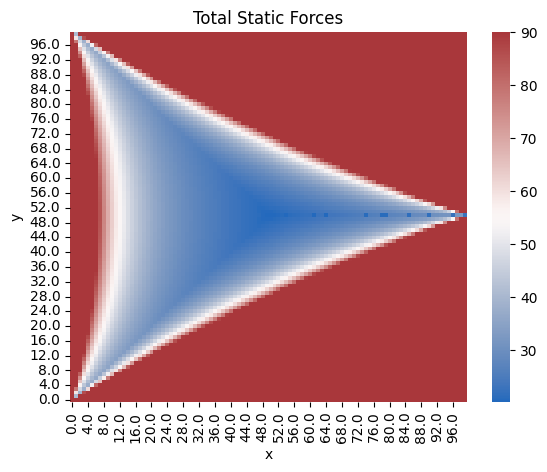

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


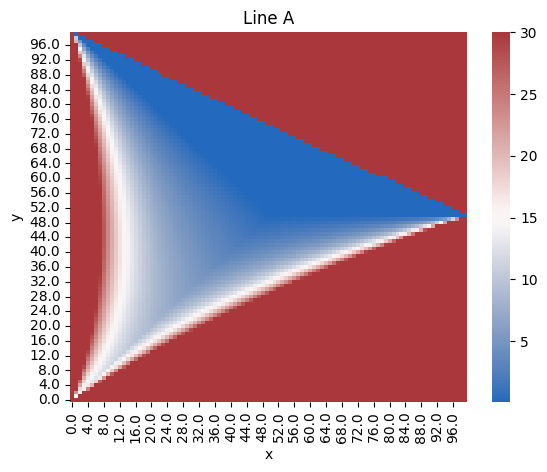

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


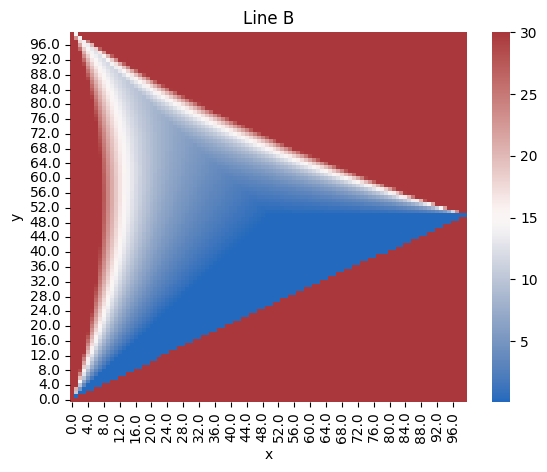

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


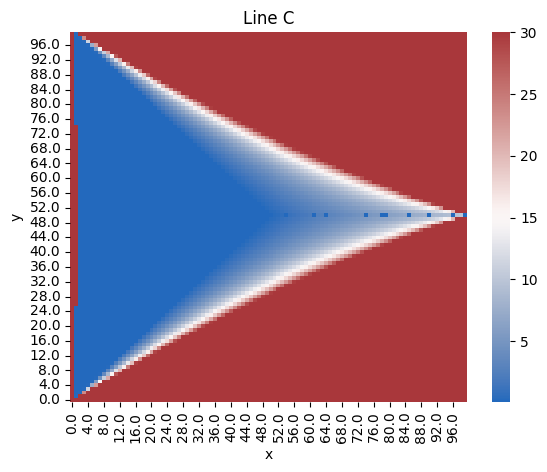

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


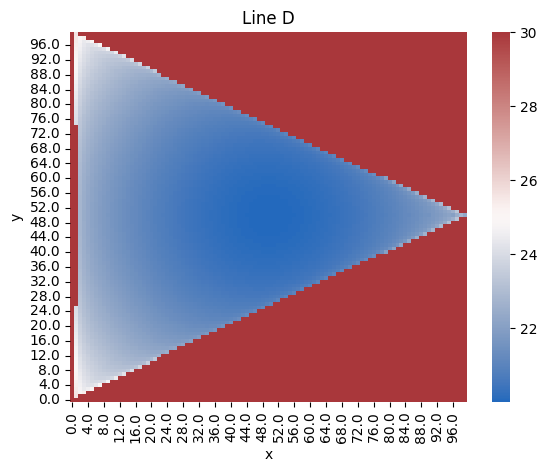

In [ ]:
plot_heatmap(grid, forces, anchors, plot_max_force=30)

In [ ]:
%%time
grid, forces = optimize_heatmap(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y)

CPU times: user 11 s, sys: 291 ms, total: 11.3 s
Wall time: 12.6 s


<ipython-input-528-5ec5214b2ba3>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = pd.DataFrame(np.hstack([grid[:, :2], forces.sum(axis=1)[:, None]]), columns=['x', 'y', 'total_force']).pivot('y', 'x', 'total_force')


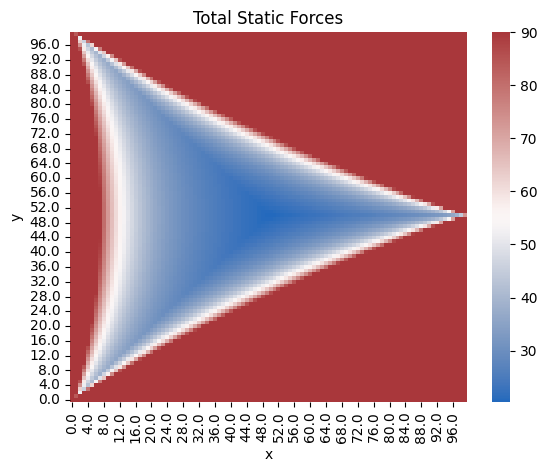

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


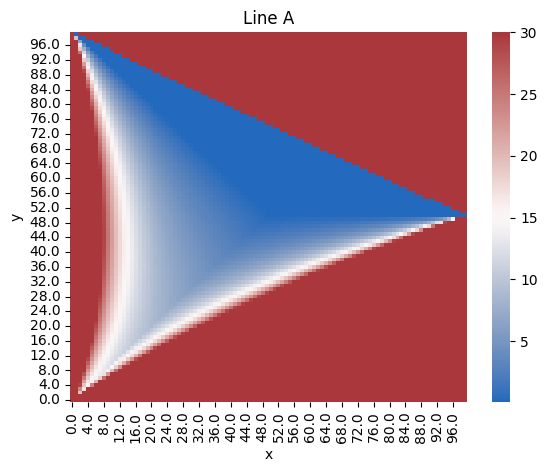

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


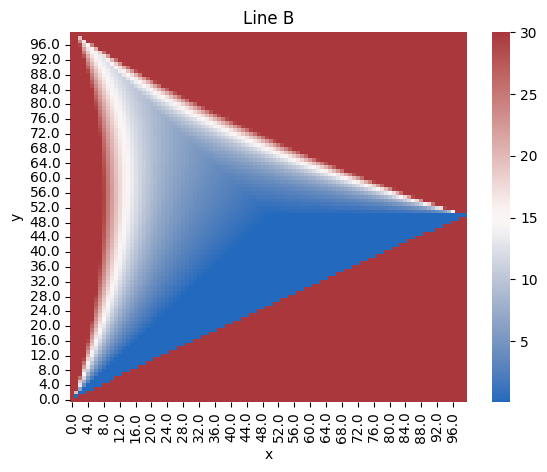

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


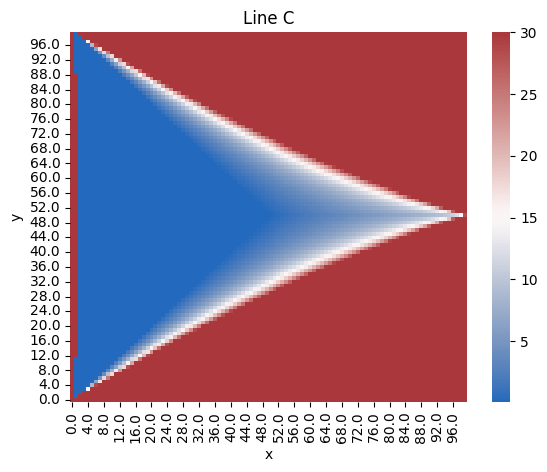

<ipython-input-528-5ec5214b2ba3>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.sort_values('x', ascending=True).pivot('y', 'x', f'force_{axis}')


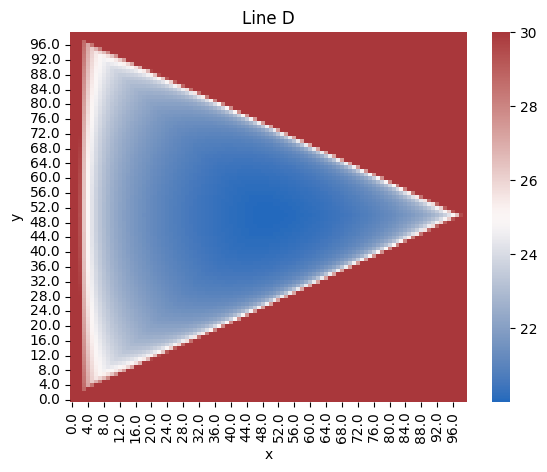

In [ ]:
plot_heatmap(grid, forces, anchors, plot_max_force=30)

## 4 Lines

In [ ]:
anchors = np.array([[0, 0,   100, 100,  50,],
                    [0, 100, 0,   100,  50,],
                    [0, 0,   0,   0,   100,]])

In [ ]:
grid, forces = optimize_heatmap(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y)

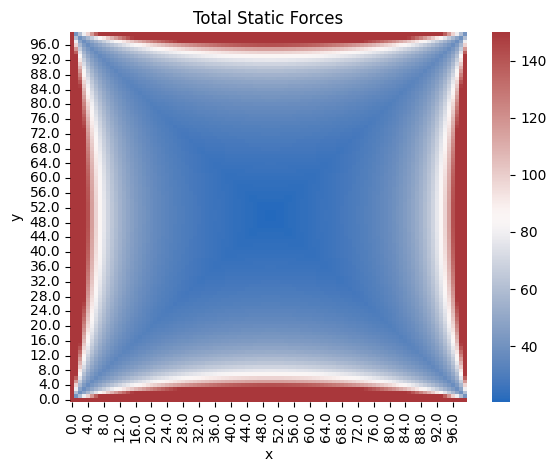

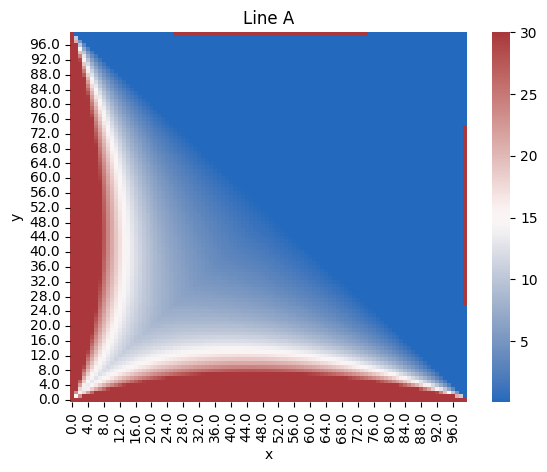

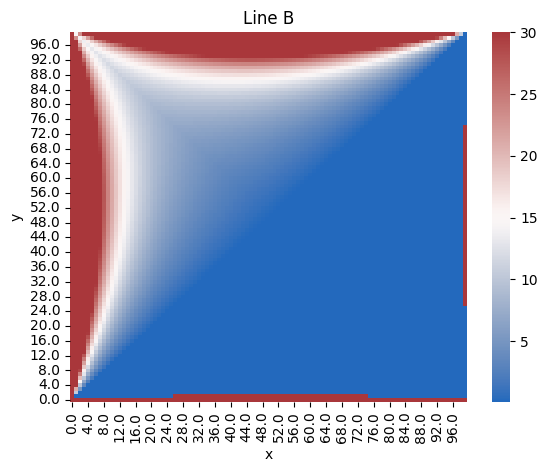

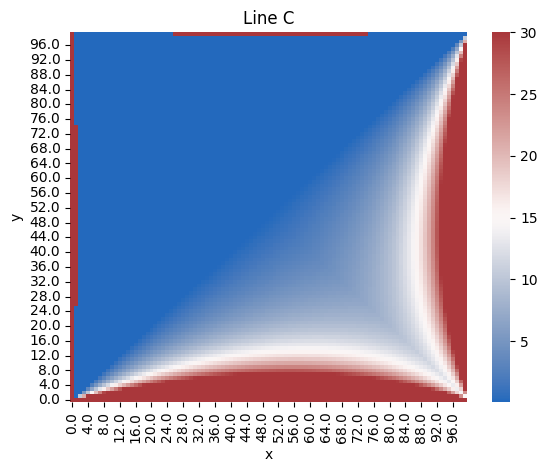

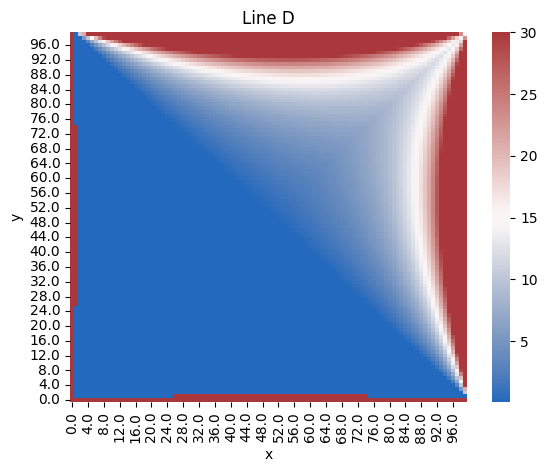

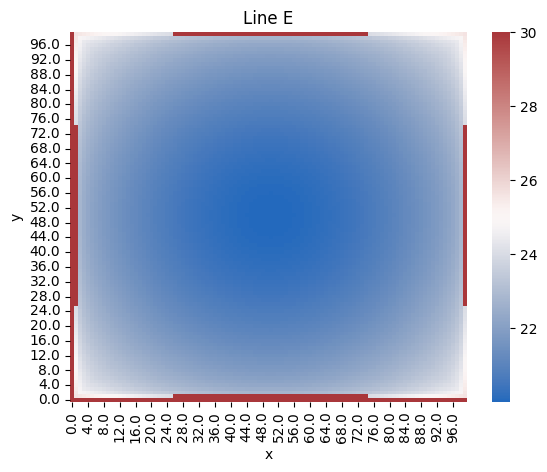

In [ ]:
plot_heatmap(grid, forces, anchors, plot_max_force=30)

## 5 Lines

In [ ]:
anchors = np.array([[0, 0,   60, 60,    100,  50,],
                    [20, 80, 0,  100,   50,  50,],
                    [0, 0,   0,   0,     0, 100,]])

In [ ]:
grid, forces = optimize_heatmap(min_tension, max_tension, weight, anchors, build_plate_x, build_plate_y)

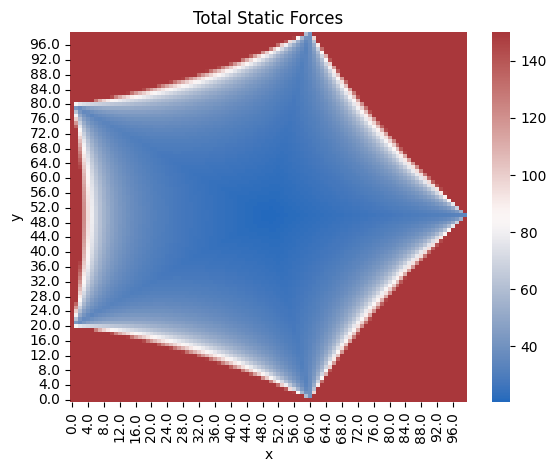

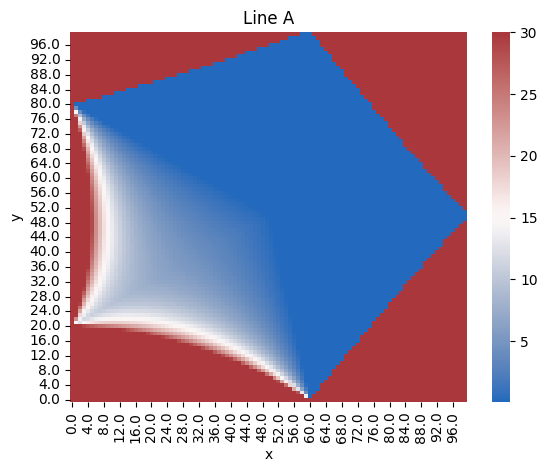

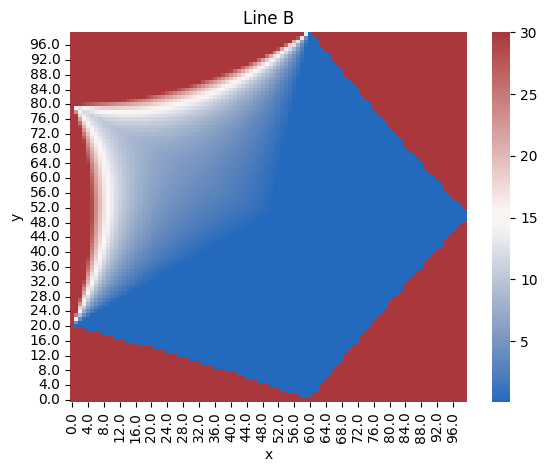

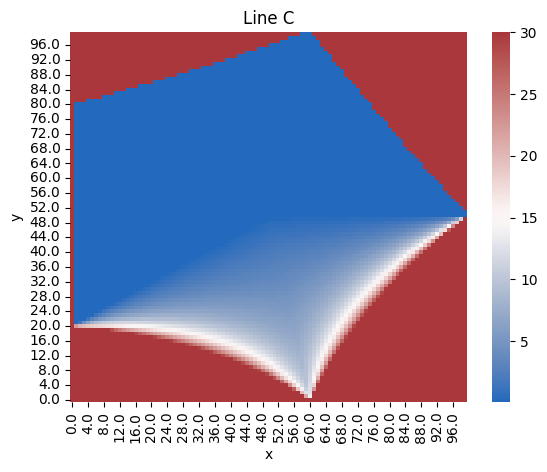

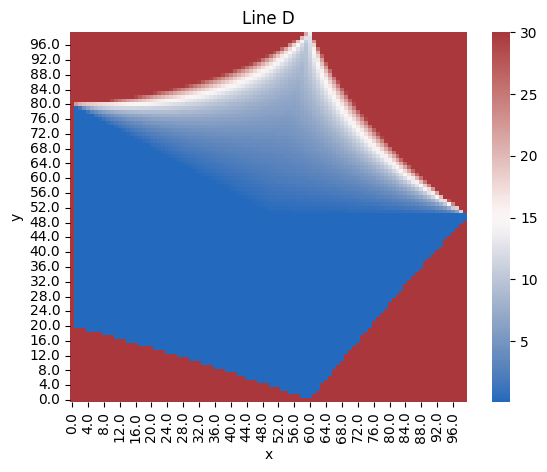

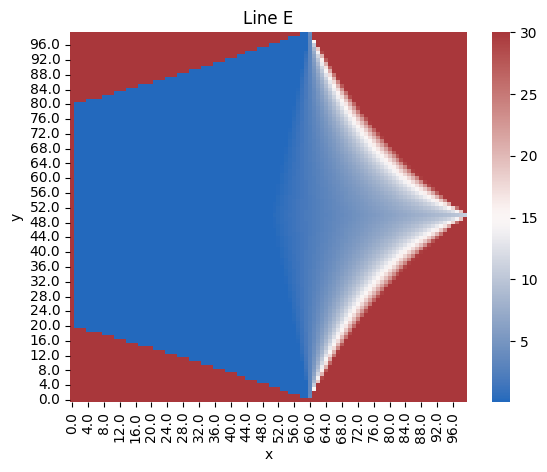

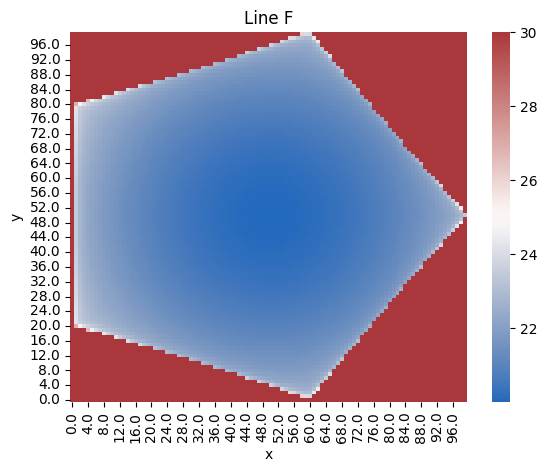

In [ ]:
plot_heatmap(grid, forces, anchors, plot_max_force=30)